In [2]:
import zipfile
import os

zip_path = "/content/archive.zip"
extract_path = "/content/fracture_dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Dataset extracted to: /content/fracture_dataset


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
from PIL import Image

In [25]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

TRAIN_PATH = "/content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train"
VAL_PATH   = "/content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val"
TEST_PATH  = "/content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test"

In [29]:
def remove_corrupt_images(folder_path):
    removed = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                print(f"Removing corrupt image: {file_path}")
                os.remove(file_path)
                removed += 1
    print(f"Total removed corrupt images in {folder_path}: {removed}")

remove_corrupt_images(TRAIN_PATH)
remove_corrupt_images(VAL_PATH)
remove_corrupt_images(TEST_PATH)

Total removed corrupt images in /content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train: 0
Total removed corrupt images in /content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val: 0
Total removed corrupt images in /content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test: 0


In [31]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
class_names = train_ds_raw.class_names
print("Classes:", class_names)

train_ds = train_ds_raw.map(lambda x, y: (x, y)).apply(tf.data.experimental.ignore_errors())

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = val_ds_raw.map(lambda x, y: (x, y)).apply(tf.data.experimental.ignore_errors())

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
test_ds = test_ds_raw.map(lambda x, y: (x, y)).apply(tf.data.experimental.ignore_errors())

Found 9246 files belonging to 2 classes.
Classes: ['fractured', 'not fractured']
Found 829 files belonging to 2 classes.
Found 506 files belonging to 2 classes.


In [32]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [33]:
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print("Frozen layers:", fine_tune_at)
print("Trainable layers:", len(base_model.layers) - fine_tune_at)

inputs = layers.Input(shape=(224,224,3))
x = data_aug(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()

Frozen layers: 122
Trainable layers: 53


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 224, 224,  │          0 │ get_item_9[0][0], │
│                     │ 3)                │            │ get_item_10[0][0… │
│                     │                   │            │ get_item_11[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 224, 224,  │          0 │ stack_3[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_3[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 2)         │        514 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,120,962 (92.01 MB)

 Trainable params: 17,742,594 (67.68 MB)

 Non-trainable params: 6,378,368 (24.33 MB)

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [35]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
    572/Unknown 94s 136ms/step - accuracy: 0.8707 - loss: 0.3243

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


572/572 ━━━━━━━━━━━━━━━━━━━━ 101s 148ms/step - accuracy: 0.8708 - loss: 0.3241 - val_accuracy: 0.9591 - val_loss: 0.1292 - learning_rate: 1.0000e-04
Epoch 2/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 138s 142ms/step - accuracy: 0.9815 - loss: 0.0526 - val_accuracy: 0.9699 - val_loss: 0.0701 - learning_rate: 1.0000e-04
Epoch 3/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 144ms/step - accuracy: 0.9892 - loss: 0.0323 - val_accuracy: 0.9773 - val_loss: 0.0513 - learning_rate: 1.0000e-04
Epoch 4/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 81s 142ms/step - accuracy: 0.9849 - loss: 0.0446 - val_accuracy: 0.9714 - val_loss: 0.0870 - learning_rate: 1.0000e-04
Epoch 5/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 81s 142ms/step - accuracy: 0.9951 - loss: 0.0134 - val_accuracy: 0.9482 - val_loss: 0.2157 - learning_rate: 1.0000e-04
Epoch 6/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 81s 142ms/step - accuracy: 0.9885 - loss: 0.0409 - val_accuracy: 0.9823 - val_loss: 0.0491 - learning_rate: 1.0000e-04
Epoch 7/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 81s 142ms/step 

In [36]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.9959 - loss: 0.0207
Test Accuracy: 98.78%


In [37]:
model.save("/content/resnet50_finetuned_fracture.h5")
print("Model saved successfully!")

Model saved successfully!


In [42]:
model.save_weights("/content/resnet50_finetuned_fracture.weights.h5")

Saving images.jpeg to images (5).jpeg
Uploaded image: images (5).jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


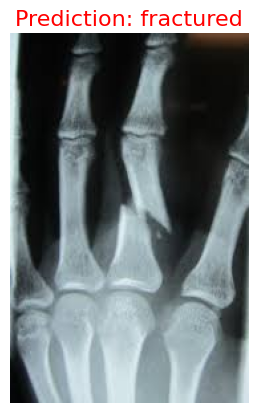

In [48]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = list(uploaded.keys())[0]
print(f"Uploaded image: {img_path}")

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)
model = models.Model(base_model.input, outputs)

weights_path = "/content/resnet50_finetuned_fracture.weights.h5"
model.load_weights(weights_path)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

img = Image.open(img_path).convert("RGB")
img_resized = img.resize((224,224))  # للـ model
img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

preds = model.predict(img_array)
class_idx = np.argmax(preds, axis=1)[0]
class_names = ['fractured', 'not fractured']
pred_label = class_names[class_idx]

plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred_label}", fontsize=16, color='red')
plt.show()